## Import necessary libraries

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

# System and file handling
import os
import glob
from pathlib import Path
import random
import shutil

# Progress tracking and utilities
from tqdm import tqdm
import time
import copy
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import cv2

# Vision-specific imports
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder

## Data Preparation

### Load metadata

In [64]:
data = '../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

df = pd.read_csv(data)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [66]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [67]:
df['age'].value_counts()

age
45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: count, dtype: int64

In [68]:
# Handle missing age values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')  
df['age'] = imputer.fit_transform(df[['age']]).ravel()

In [69]:
df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [70]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [71]:
dx_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['diagnosis'] = df['dx'].map(dx_dict.get) 

In [72]:
df['diagnosis'].value_counts()

diagnosis
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

In [73]:
# Create numerical labels
label_dict = {v: k for k, v in enumerate(dx_dict.keys())}
df['label'] = df['dx'].map(label_dict)

df['label'].head()

0    2
1    2
2    2
3    2
4    2
Name: label, dtype: int64

In [74]:
# Set image directory paths
image_dir = '../input/skin-cancer-mnist-ham10000'
part1_path = os.path.join(image_dir, 'ham10000_images_part_1')
part2_path = os.path.join(image_dir, 'ham10000_images_part_2')

In [75]:
# Create image path column
def find_image_path(image_id):
    for path in [part1_path, part2_path]:
        img_path = os.path.join(path, image_id + '.jpg')
        if os.path.exists(img_path):
            return img_path
    return None

df['path'] = df['image_id'].apply(find_image_path)

# Verify we found all images
print(f"Missing images: {df['path'].isnull().sum()}/{len(df)}")

Missing images: 0/10015


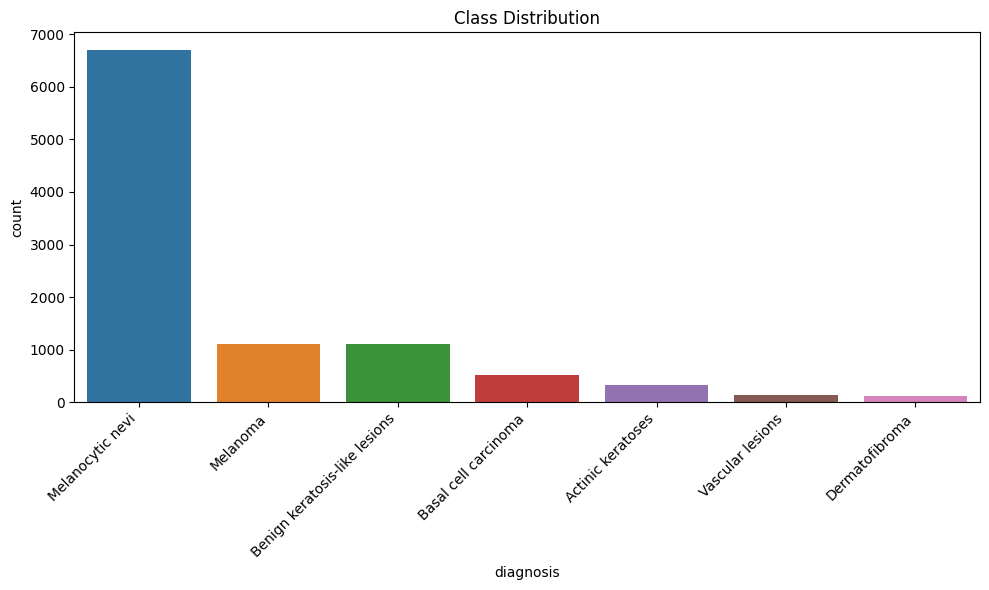

In [76]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='diagnosis', order=df['diagnosis'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

In [77]:
# PyTorch Dataset Class 
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.diagnosis_names = df['diagnosis'].values
        self.image_ids = df['image_id'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label']
        diagnosis = self.df.iloc[idx]['diagnosis']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, diagnosis, self.image_ids[idx]

In [78]:
# Data Augmentation and Transformation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value='random')
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [79]:
# Calculate class weights for imbalanced data
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = 1. / class_counts
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted sampler for training
sample_weights = weights[train_df['label'].values]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [80]:
# Train-Validation-Test Split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"\nDataset Split:")
print(f"Train: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"Validation: {len(val_df)} ({len(val_df)/len(df):.1%})")
print(f"Test: {len(test_df)} ({len(test_df)/len(df):.1%})")


Dataset Split:
Train: 7010 (70.0%)
Validation: 1502 (15.0%)
Test: 1503 (15.0%)


In [81]:
# Create datasets
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_transform)
test_dataset = SkinCancerDataset(test_df, transform=val_transform)

In [82]:
# Compute class weights for imbalanced data
train_labels = train_df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("\nClass weights:", class_weights)


Class weights: tensor([ 0.2134,  1.2855,  1.3022,  2.7817,  4.3731, 10.1154, 12.3633])


In [83]:
# Data Loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Model Setup

In [84]:
# Using pre-trained ResNet18
model = models.resnet18(pretrained=True)

In [85]:
# Modify final layer for our 7 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [87]:
# Loss and Optimizer with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

In [88]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels, _, _ in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())  # Convert to float
        
        print(f'Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc.item():.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        for inputs, labels, _, _ in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
        
        val_loss = val_loss / len(val_dataset)
        val_acc = val_corrects.double() / len(val_dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())  # Convert to float
        
        print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc.item():.4f}')
        
        # Update learning rate
        scheduler.step(val_acc)  # Can use tensor or float
        
        # Save best model
        if val_acc > best_acc:  # Tensor comparison is fine
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with val_acc: {val_acc.item():.4f}')
    
    print(f'\nBest val Acc: {best_acc.item():.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [89]:
# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=15)


Epoch 1/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.41it/s]


Train Loss: 1.8259 | Acc: 0.3922


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.40it/s]


Val Loss: 1.6863 | Acc: 0.5513
New best model saved with val_acc: 0.5513

Epoch 2/15
----------


Training: 100%|██████████| 220/220 [01:05<00:00,  3.34it/s]


Train Loss: 1.7182 | Acc: 0.4361


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.65it/s]


Val Loss: 1.7178 | Acc: 0.5013

Epoch 3/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.39it/s]


Train Loss: 1.6053 | Acc: 0.4478


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.66it/s]


Val Loss: 1.4517 | Acc: 0.5739
New best model saved with val_acc: 0.5739

Epoch 4/15
----------


Training: 100%|██████████| 220/220 [01:03<00:00,  3.45it/s]


Train Loss: 1.5709 | Acc: 0.4989


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.55it/s]


Val Loss: 1.4031 | Acc: 0.5020

Epoch 5/15
----------


Training: 100%|██████████| 220/220 [01:03<00:00,  3.44it/s]


Train Loss: 1.5688 | Acc: 0.4545


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


Val Loss: 1.4813 | Acc: 0.6598
New best model saved with val_acc: 0.6598

Epoch 6/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.40it/s]


Train Loss: 1.5124 | Acc: 0.5050


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.64it/s]


Val Loss: 1.4905 | Acc: 0.6252

Epoch 7/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.41it/s]


Train Loss: 1.5851 | Acc: 0.4837


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


Val Loss: 2.0825 | Acc: 0.4960

Epoch 8/15
----------


Training: 100%|██████████| 220/220 [01:03<00:00,  3.45it/s]


Train Loss: 1.4702 | Acc: 0.5001


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.47it/s]


Val Loss: 1.2872 | Acc: 0.4767

Epoch 9/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.43it/s]


Train Loss: 1.3790 | Acc: 0.5317


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.86it/s]


Val Loss: 1.2403 | Acc: 0.5806

Epoch 10/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Train Loss: 1.2304 | Acc: 0.5645


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.75it/s]


Val Loss: 1.1296 | Acc: 0.6178

Epoch 11/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.41it/s]


Train Loss: 1.2224 | Acc: 0.5700


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.54it/s]


Val Loss: 1.0838 | Acc: 0.6431

Epoch 12/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Train Loss: 1.2101 | Acc: 0.5916


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.58it/s]


Val Loss: 1.0922 | Acc: 0.6445

Epoch 13/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Train Loss: 1.1718 | Acc: 0.5974


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.70it/s]


Val Loss: 1.0792 | Acc: 0.6372

Epoch 14/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.40it/s]


Train Loss: 1.1720 | Acc: 0.5777


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.72it/s]


Val Loss: 1.0665 | Acc: 0.6398

Epoch 15/15
----------


Training: 100%|██████████| 220/220 [01:04<00:00,  3.42it/s]


Train Loss: 1.1554 | Acc: 0.5845


Validation: 100%|██████████| 47/47 [00:08<00:00,  5.46it/s]

Val Loss: 1.0627 | Acc: 0.6411

Best val Acc: 0.6598


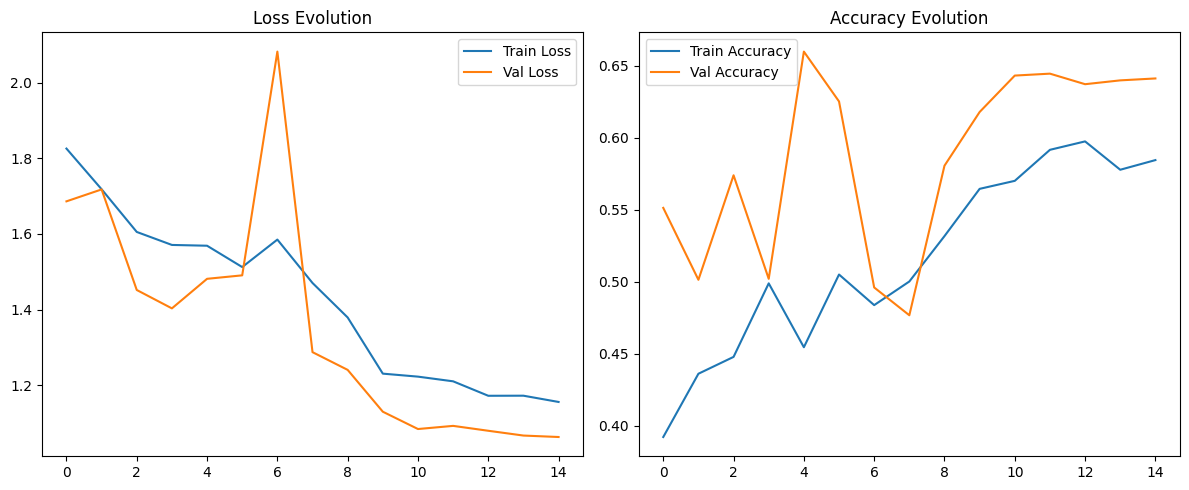

In [90]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [91]:
# Evaluation Function 
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_diagnoses = []
    all_image_ids = []
    
    for inputs, labels, diagnoses, image_ids in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_diagnoses.extend(diagnoses)
        all_image_ids.extend(image_ids)
    
    return all_preds, all_labels, all_diagnoses, all_image_ids

In [92]:
# Evaluate on test set
test_preds, test_labels, test_diagnoses, test_image_ids = evaluate(model, test_loader)
test_acc = np.mean(np.array(test_preds) == np.array(test_labels))
print(f'\nTest Accuracy: {test_acc:.4f}')

Testing: 100%|██████████| 47/47 [00:09<00:00,  5.09it/s]


Test Accuracy: 0.6540


In [93]:
# Create results DataFrame
results_df = pd.DataFrame({
    'image_id': test_image_ids,
    'true_label': test_labels,
    'predicted_label': test_preds,
    'true_diagnosis': test_diagnoses,
    'predicted_diagnosis': [list(dx_dict.values())[l] for l in test_preds]
})

In [94]:
# Add correctness flag
results_df['correct'] = results_df['true_label'] == results_df['predicted_label']

# Save results
results_df.to_csv('test_results.csv', index=False)

In [95]:
# Get diagnosis names in correct order
diagnosis_names = [dx_dict[k] for k in label_dict.keys()]

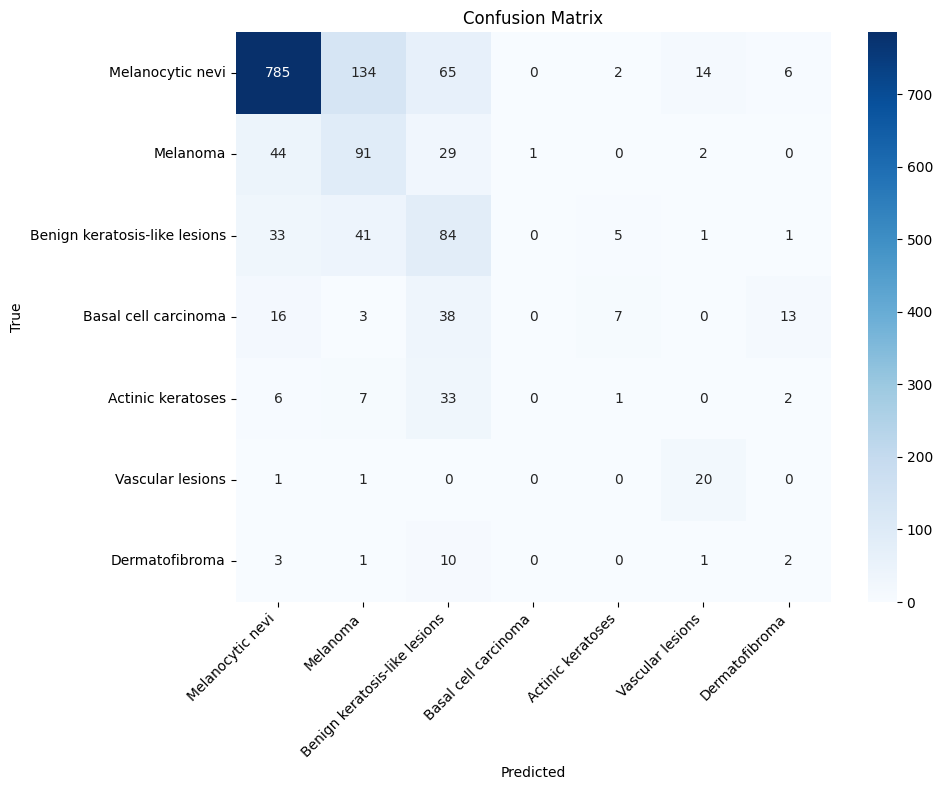

In [96]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=diagnosis_names, 
            yticklabels=diagnosis_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show();

In [97]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=diagnosis_names))


Classification Report:
                               precision    recall  f1-score   support

             Melanocytic nevi       0.88      0.78      0.83      1006
                     Melanoma       0.33      0.54      0.41       167
Benign keratosis-like lesions       0.32      0.51      0.40       165
         Basal cell carcinoma       0.00      0.00      0.00        77
            Actinic keratoses       0.07      0.02      0.03        49
             Vascular lesions       0.53      0.91      0.67        22
               Dermatofibroma       0.08      0.12      0.10        17

                     accuracy                           0.65      1503
                    macro avg       0.32      0.41      0.35      1503
                 weighted avg       0.67      0.65      0.66      1503




Number of errors: 520/1503

Sample Errors:
        image_id  true_label  predicted_label                 true_diagnosis  \
2   ISIC_0029297           6                0                 Dermatofibroma   
5   ISIC_0026296           1                0                       Melanoma   
7   ISIC_0028499           4                2              Actinic keratoses   
8   ISIC_0028653           3                2           Basal cell carcinoma   
13  ISIC_0024743           3                6           Basal cell carcinoma   
15  ISIC_0029100           2                1  Benign keratosis-like lesions   
20  ISIC_0031552           3                6           Basal cell carcinoma   
24  ISIC_0033102           0                1               Melanocytic nevi   
25  ISIC_0027076           1                0                       Melanoma   
28  ISIC_0031149           0                1               Melanocytic nevi   

              predicted_diagnosis  correct  
2                Melanocytic n

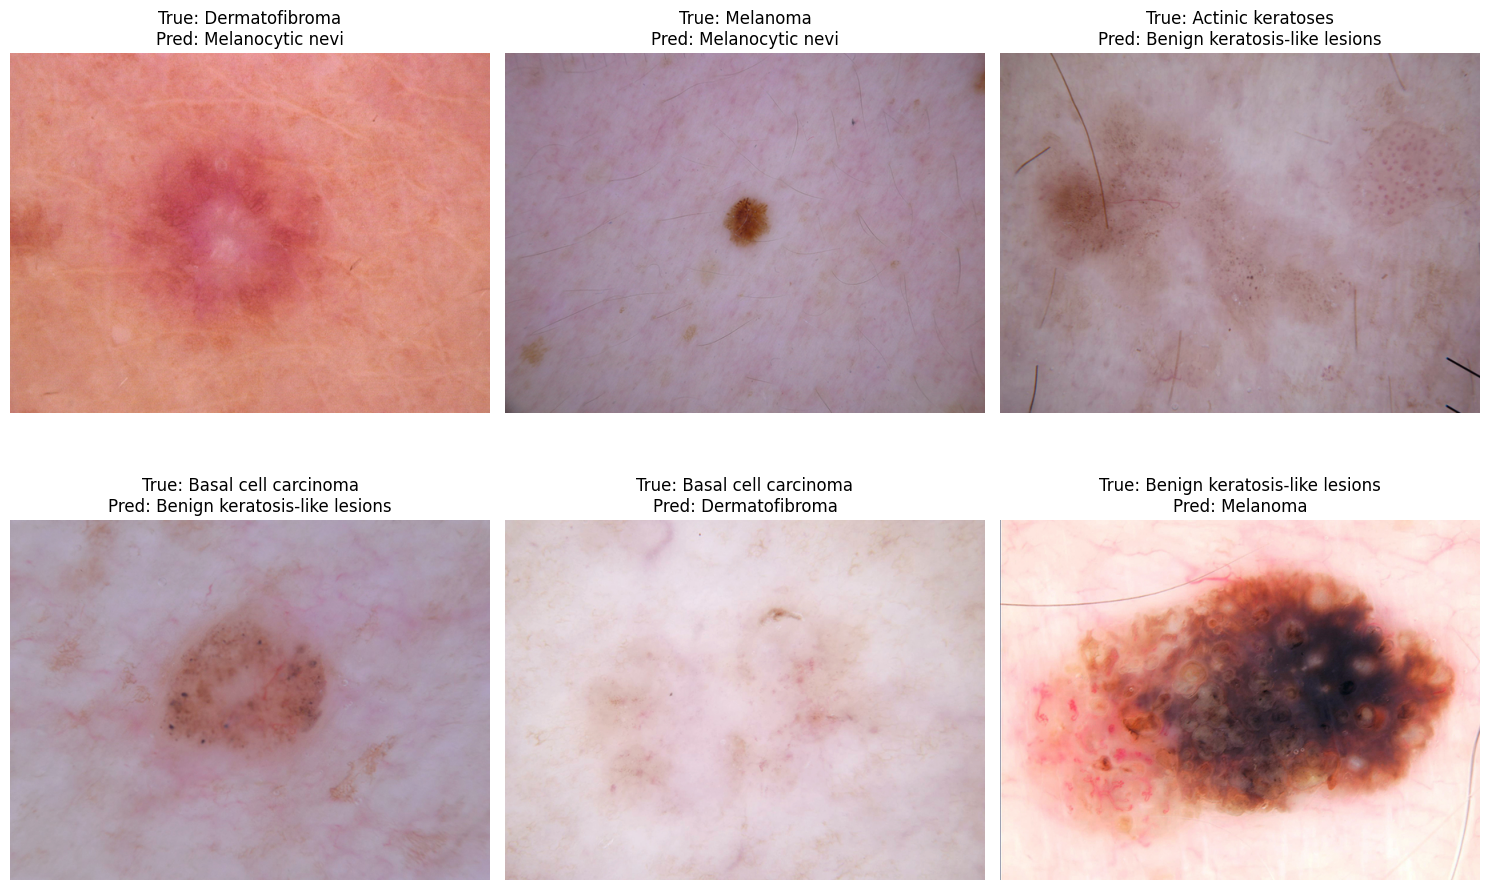

In [98]:
# Analyze errors
error_df = results_df[results_df['correct'] == False]
print(f"\nNumber of errors: {len(error_df)}/{len(results_df)}")

if not error_df.empty:
    print("\nSample Errors:")
    print(error_df.head(10))
    
    # Plot some error cases
    plt.figure(figsize=(15, 10))
    for i, (_, row) in enumerate(error_df.head(6).iterrows()):
        img_path = find_image_path(row['image_id'])
        img = Image.open(img_path)
        
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {row['true_diagnosis']}\nPred: {row['predicted_diagnosis']}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('error_samples.png')
    plt.show();